## **DATASET DOWNLOAD FROM KAGGLE**


In [1]:
##!pip install -q kaggle

In [2]:
##from google.colab import files
##files.upload()

In [3]:
import os
import shutil
from shutil import copyfile

In [4]:
##%cd /content/drive/MyDrive/object_detection/ 

In [5]:
##os.makedirs('vehicle_number_plate', exist_ok=True)

In [6]:
##%cd ./vehicle_number_plate/

In [7]:
##shutil.copy('/content/kaggle.json', '/content/drive/MyDrive/object_detection/vehicle_number_plate/')

In [8]:
##!chmod 600 /content/drive/MyDrive/object_detection/vehicle_number_plate/kaggle.json

In [9]:
##!kaggle datasets download -d dataturks/vehicle-number-plate-detection

In [10]:
##!unzip vehicle-number-plate-detection.zip 

## RETINANET

In [11]:
%cd /content/drive/MyDrive/object_detection/

/content/drive/MyDrive/object_detection


In [12]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [13]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [14]:
%cd ./keras-retinanet/

/content/drive/MyDrive/object_detection/keras-retinanet


In [15]:
!pip install .

Processing /content/drive/MyDrive/object_detection/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=167044 sha256=f2c734cef5550ba56d19860a22b8e1bcadb6430c53ecde4de95d5f62ed4ecc2b
  Stored in directory: /root/.cache/pip/wheels/d4/58/e1/95f1e969ea195edf31b238e1acd98df2387940d6b4df91100a
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [16]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [17]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import requests
from tensorflow import keras
from sklearn.model_selection import train_test_split
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline

RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [18]:
df = pd.read_json('/content/drive/MyDrive/object_detection/vehicle_number_plate/Indian_Number_plates.json', lines=True)

In [19]:
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [20]:
import json
j = json.loads(open('/content/drive/MyDrive/object_detection/vehicle_number_plate/Indian_Number_plates.json').readline())

In [21]:
j

{'annotation': [{'imageHeight': 466,
   'imageWidth': 806,
   'label': ['number_plate'],
   'notes': '',
   'points': [{'x': 0.7220843672456576, 'y': 0.5879828326180258},
    {'x': 0.8684863523573201, 'y': 0.6888412017167382}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg',
 'extras': None}

In [22]:
df.shape

(237, 3)

In [23]:
if not os.path.exists('vehicle'):
  os.makedirs('vehicle')

In [24]:
converted_data_train = {
    'image_name':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'class_name':[],
}

converted_data_test = {
    'image_name':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'class_name':[],
}

In [25]:
idx = 0

def map_to_data(row, converted_data):
  global idx
  r = requests.get(row['content'])
  filepath = 'vehicle/vehicle_%s.jpg' %idx
  
  if not os.path.exists(filepath):
    with open(filepath, 'wb') as f:
      f.write(r.content)

  for anno in row['annotation']:
    converted_data['image_name'].append(filepath)

    width = anno['imageWidth']
    height = anno['imageHeight']

    x1 = int(round(anno['points'][0]['x'] * width))
    y1 = int(round(anno['points'][0]['y'] * height))
    x2 = int(round(anno['points'][1]['x'] * width))
    y2 = int(round(anno['points'][1]['y'] * height))

    converted_data['x_min'].append(x1)
    converted_data['y_min'].append(y1)
    converted_data['x_max'].append(x2)
    converted_data['y_max'].append(y2)

    converted_data['class_name'].append('license_plate')
  
  idx += 1


In [26]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [27]:
idx = 0

train_df.apply(lambda row: map_to_data(row, converted_data_train), axis=1)

test_df.apply(lambda row: map_to_data(row, converted_data_test), axis=1)

74     None
90     None
4      None
201    None
41     None
88     None
118    None
32     None
172    None
66     None
210    None
198    None
169    None
37     None
185    None
78     None
224    None
149    None
112    None
119    None
117    None
125    None
96     None
69     None
121    None
153    None
167    None
154    None
123    None
114    None
55     None
12     None
34     None
179    None
236    None
31     None
194    None
35     None
85     None
39     None
199    None
178    None
65     None
209    None
208    None
191    None
33     None
80     None
dtype: object

In [28]:
train_df= pd.DataFrame(converted_data_train)
test_df= pd.DataFrame(converted_data_test)
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,vehicle/vehicle_0.jpg,133,218,488,424,license_plate
1,vehicle/vehicle_1.jpg,313,291,1126,531,license_plate
2,vehicle/vehicle_2.jpg,250,506,487,584,license_plate
3,vehicle/vehicle_3.jpg,26,262,164,329,license_plate
4,vehicle/vehicle_4.jpg,99,205,409,311,license_plate


In [29]:
train_df.shape

(195, 6)

In [30]:
def show_image_with_boxes(df):

  filepath = df.sample().image_name.values[0]
  df2 = df[df.image_name == filepath]
  im = np.array(Image.open(filepath))

  im = im[:,:,:3]

  for index, row in df2.iterrows():
    box = [
           row.x_min, row.y_min, row.x_max, row.y_max
    ]
    print(box)
    draw_box(im, box, color=(255,0,0))
  
  plt.axis('off')
  plt.imshow(im)
  plt.show()

[144, 113, 348, 199]


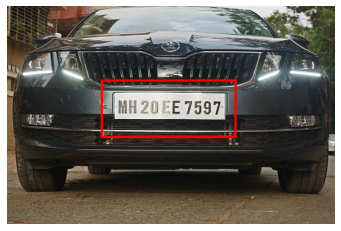

In [31]:
show_image_with_boxes(train_df)

In [32]:
train_df.to_csv('annotations.csv', index=False, header=None)

In [33]:
classes = ['license_plate']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name}, {i}\n')

In [34]:
!head classes.csv

license_plate, 0


In [35]:
!head annotations.csv

vehicle/vehicle_0.jpg,133,218,488,424,license_plate
vehicle/vehicle_1.jpg,313,291,1126,531,license_plate
vehicle/vehicle_2.jpg,250,506,487,584,license_plate
vehicle/vehicle_3.jpg,26,262,164,329,license_plate
vehicle/vehicle_4.jpg,99,205,409,311,license_plate
vehicle/vehicle_5.jpg,146,134,395,196,license_plate
vehicle/vehicle_6.jpg,26,64,214,148,license_plate
vehicle/vehicle_6.jpg,12,17,248,48,license_plate
vehicle/vehicle_7.jpg,274,344,517,431,license_plate
vehicle/vehicle_8.jpg,58,150,171,206,license_plate


In [36]:
if not os.path.exists('snapshots'):
  os.makedirs('snapshots')

In [37]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)



('snapshots/_pretrained_model.h5', <http.client.HTTPMessage at 0x7efe7e076940>)

In [38]:
!chmod 755 -R /content/drive/MyDrive/object_detection/keras-retinanet/keras_retinanet/bin/train.py

In [39]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 24 --epochs 20 csv annotations.csv classes.csv

2020-12-29 13:40:29.404551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-12-29 13:40:31.721443: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-29 13:40:31.722609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-29 13:40:31.763391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-29 13:40:31.763951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-29 13:40:31.763985: I tensorflow/

In [40]:
from glob import glob
model_paths = glob('snapshots/resnet50_csv_*.h5')
second_last_path = sorted(model_paths)[-2]
print('path:', second_last_path)

path: snapshots/resnet50_csv_19.h5


In [41]:
model = models.load_model(second_last_path, backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

In [44]:
def show_image_with_predictions(df, threshold = 0.6):
  row = df.sample()
  filepath = row['image_name'].values[0]
  print('filepath:', filepath)

  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print('im.shape:', im.shape)

  im = im[:,:,:3]

  for index, row in df2.iterrows():
    box = [
           row.x_min, row.y_min, row.x_max, row.y_max
    ]
    print(box)
    draw_box(im, box, color=(255,0,0))

  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(np.expand_dims(imp, axis=0))

  boxes /= scale

  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


filepath: vehicle/vehicle_152.jpg
im.shape: (239, 249, 3)
[13, 117, 147, 186]


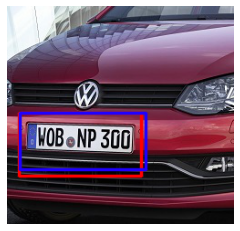

In [48]:
show_image_with_predictions(train_df, threshold=0.3)